In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from scipy import stats

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import create_engine, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement= Base.classes.measurement
Station= Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [12]:
#Get a list of column name and types
inspector = inspect(engine)

measurement_columns = inspector.get_columns('measurement')
print("Measurement")
for columns in measurement_columns:
    print(columns['name'], columns["type"])
    
station_columns = inspector.get_columns('station')
print("\nStations")
for columns in station_columns:
    print(columns['name'], columns["type"])

Measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

Stations
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
session.query(func.count(Measurement.date)).all()


[(19550)]

In [14]:
early = session.query(Measurement.date).order_by(Measurement.date).first()
latest = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"Early: {early[0]} , Latest: {latest[0]}")

Early: 2010-01-01 , Latest: 2017-08-23


In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date


latestdate = dt.datetime.strptime(latest[0], '%Y-%m-%d')
querydate = dt.date(latestdate.year -1, latestdate.month, latestdate.day)
querydate

prec_db = [Measurement.date,Measurement.prcp]
queryresult = session.query(*prec_db).filter(Measurement.date >= querydate).all()

preci = pd.DataFrame(queryresult, columns=['Date','Precipitation'])
preci = preci.dropna(how='any')
preci = preci.sort_values(["Date"], ascending=True)
preci = preci.set_index("Date")
preci

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.08


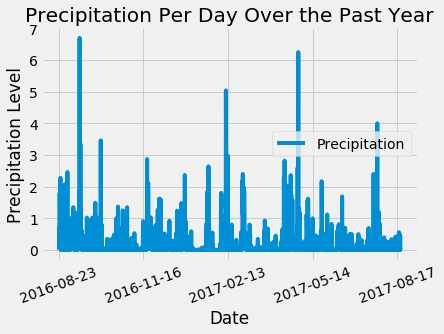

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = preci.plot(rot=20);
ax.set_title("Precipitation Per Day Over the Past Year");
ax.set_ylabel("Precipitation Level");

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
preci.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.id).count()

9

In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
prec_db = [Measurement.station,func.count(Measurement.id)]
active_stat = session.query(*prec_db).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()
active_stat

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
prec_db = [func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
mas= session.query(*prec_db).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).first()
mas

(54.0, 85.0, 71.66378066378067)

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
queryresult = session.query(Measurement.date,Measurement.tobs).\
    filter(Measurement.station == active_stat[0][0]).\
    filter(Measurement.date >= querydate).all()
temperatures = list(np.ravel(queryresult))

temperatures[:5]

['2016-08-23', '77.0', '2016-08-24', '77.0', '2016-08-25']

In [23]:
prec_db = [Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation]
queryresult = session.query(*prec_db).all()
stations_desc = pd.DataFrame(queryresult, columns=['Station','Name','Latitude','Longitude','Elevation'])
stations_desc.head()


,Station,Name,Latitude,Longitude,Elevation
0,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [25]:
stationname = stations_desc.loc[stations_desc["Station"] == active_stat[0][0],"Name"].tolist()[0]
stationname

'WAIHEE 837.5, HI US'

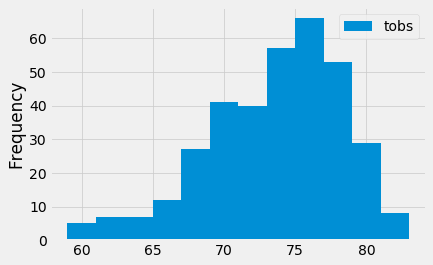

In [28]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

queryresult = session.query(Measurement.tobs).\
    filter(Measurement.station ==  active_stat[0][0]).\
    filter(Measurement.date >= querydate).all()
temperatures = list(np.ravel(queryresult))

stationname = stations_desc.loc[stations_desc["Station"] == active_stat[0][0],"Name"].tolist()[0]
plt.hist(temperatures, bins=12,rwidth=3.0,label='tobs')
plt.grid(axis='both', alpha=0.75)
plt.ylabel('Frequency')

plt.legend()